In [1]:

import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)

import matplotlib.pyplot as plt

######################################################################
# Preparation
# -----------
#
# First, we import the modules and download the audio assets we use in this tutorial.
from IPython.display import Audio

from torchaudio.utils import download_asset

# SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
# SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

cabb_audio_path = "/home/eghaleb/Projects/MMCSGD/soxan/data/cabb/gesture/pair09_A_20710_20786.wav"

2.0.1+cu118
2.0.2+cu118


In [2]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [3]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [4]:
SAMPLE_WAV = cabb_audio_path
SAMPLE_SPEECH = cabb_audio_path
# Load the data
# Load the data
waveform1, sample_rate1 = torchaudio.load(SAMPLE_WAV)

# Define effects
effects = [
    ["lowpass", "-1", "300"],  # apply single-pole lowpass filter
    ["speed", "0.8"],  # reduce the speed
    # This only changes sample rate, so it is necessary to
    # add `rate` effect with original sample rate after this.
    ["rate", f"{sample_rate1}"],
    ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

In [33]:
# Apply effects
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(waveform1, sample_rate1, effects)

print(waveform1.shape, sample_rate1)
print(waveform2.shape, sample_rate2)


torch.Size([1, 40508]) 16000
torch.Size([2, 50635]) 16000


# Original

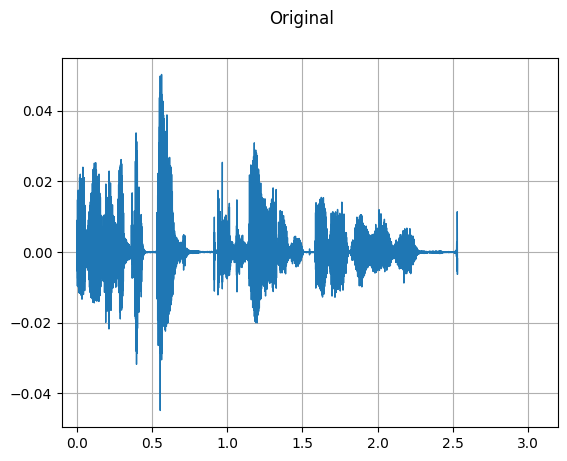

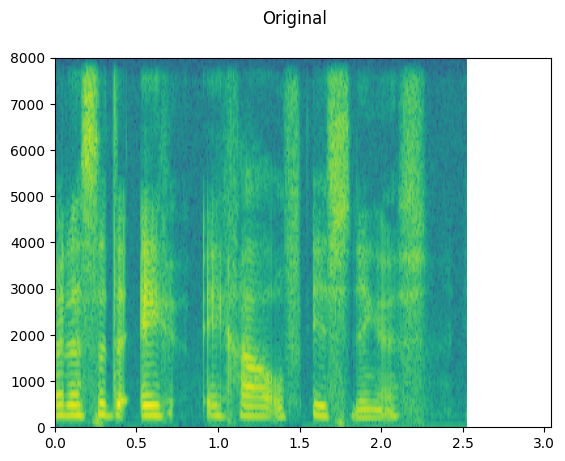

In [6]:
plot_waveform(waveform1, sample_rate1, title="Original", xlim=(-0.1, 3.2))
plot_specgram(waveform1, sample_rate1, title="Original", xlim=(0, 3.04))
Audio(waveform1, rate=sample_rate1)

In [38]:
waveform2.shape

torch.Size([2, 50635])

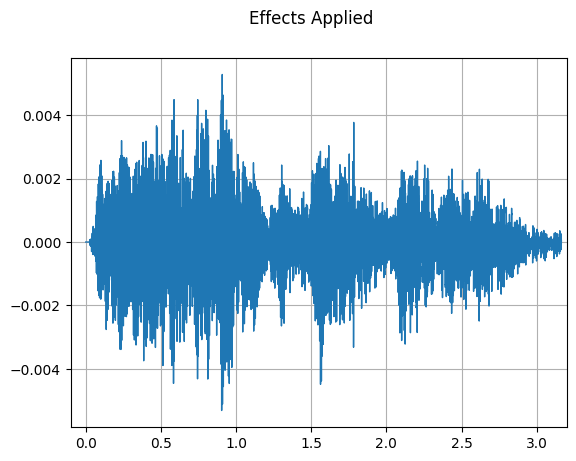

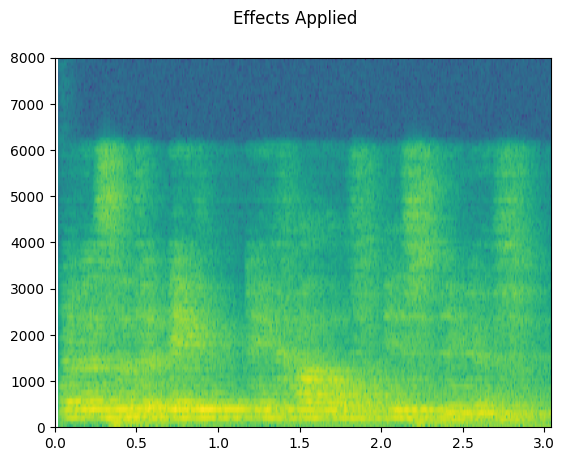

In [42]:
# choose one of the channels
waveform3 = waveform2[1, :].unsqueeze(0)
plot_waveform(waveform3, sample_rate2, title="Effects Applied", xlim=(-0.1, 3.2))
plot_specgram(waveform3, sample_rate2, title="Effects Applied", xlim=(0, 3.04))
Audio(waveform3, rate=sample_rate2)

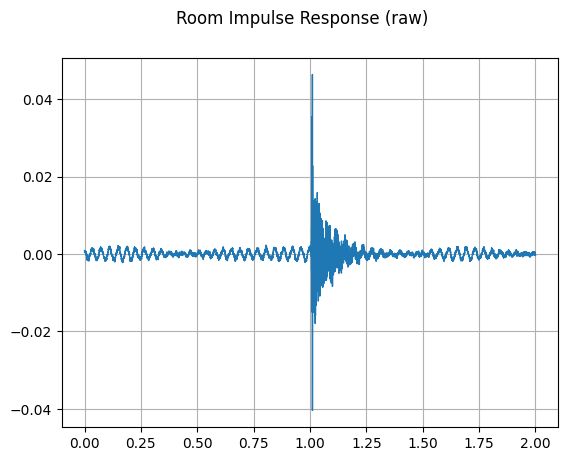

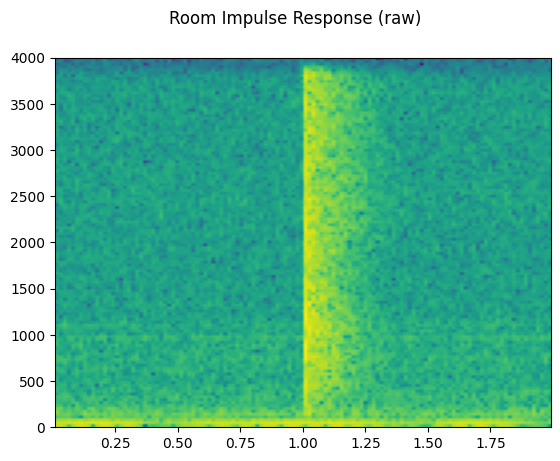

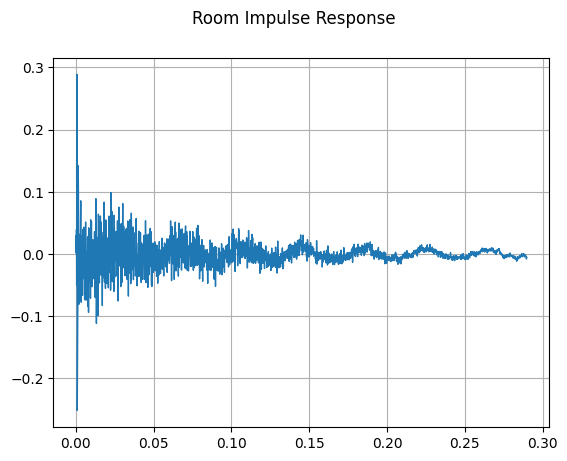

RIR work only with 8000


In [15]:
def apply_rir(speech, speech_sample_rate):
   rir_raw, sample_rate = torchaudio.load(SAMPLE_RIR)
   # resample to 16kHz
   # rir = F.resample(rir_raw, sample_rate, 16000)
   # sample_rate = 16000
   plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)")
   plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")
   Audio(rir_raw, rate=sample_rate)
   
   rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
   rir = rir / torch.norm(rir, p=2)

   plot_waveform(rir, sample_rate, title="Room Impulse Response")
   
   print('RIR work only with {}'.format(sample_rate))
   if speech_sample_rate != sample_rate:
      speech = F.resample(speech, speech_sample_rate, sample_rate)
      # speech_sample_rate = sample_rate
   augmented = F.fftconvolve(speech, rir)
   
   # resample to original sample rate
   augmented = F.resample(augmented, sample_rate, speech_sample_rate)
   
   return augmented
augmented = apply_rir(waveform1, sample_rate1)

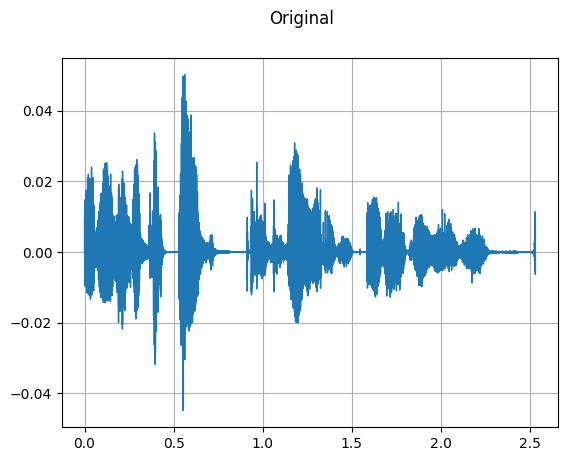

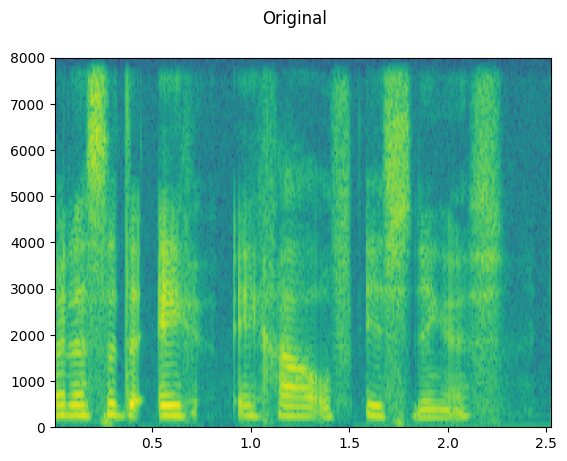

In [17]:
plot_waveform(waveform1, sample_rate1, title="Original")
plot_specgram(waveform1, sample_rate1, title="Original")
Audio(waveform1, rate=sample_rate1)

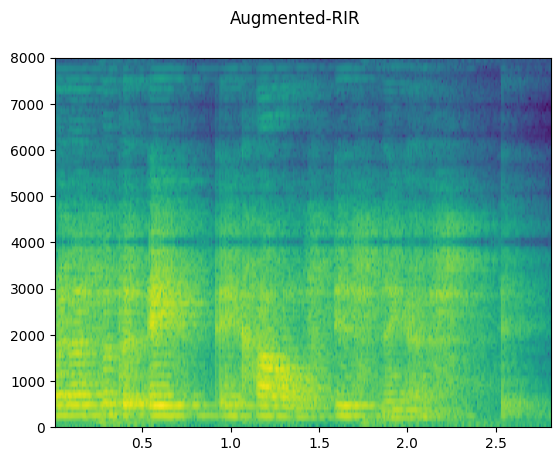

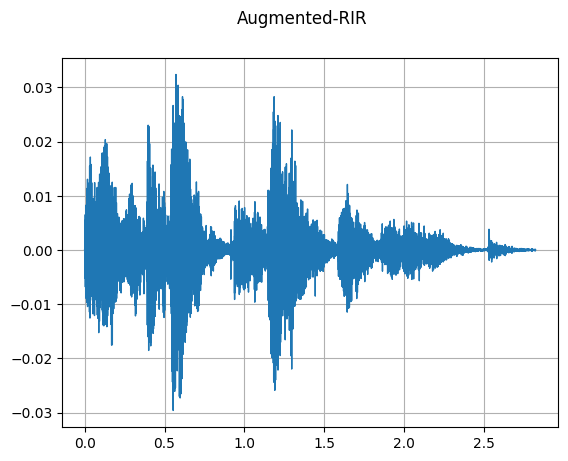

In [18]:
plot_specgram(augmented, sample_rate1, title="Augmented-RIR")
plot_waveform(augmented, sample_rate1, title="Augmented-RIR")
Audio(augmented, rate=sample_rate1)

In [21]:
noise, noise_sample_rate = torchaudio.load(SAMPLE_NOISE)
# resample to 16kHz
noise = F.resample(noise, noise_sample_rate, sample_rate1)
noise_sample_rate = sample_rate1
if noise.shape[1] < waveform1.shape[1]:
   noise = noise.repeat(1, 2)[:,:waveform1.shape[1]]
else:
   noise = noise[:, : waveform1.shape[1]]

snr_dbs = torch.tensor([20, 10, 3])
noisy_speeches = F.add_noise(waveform1, noise, snr_dbs)

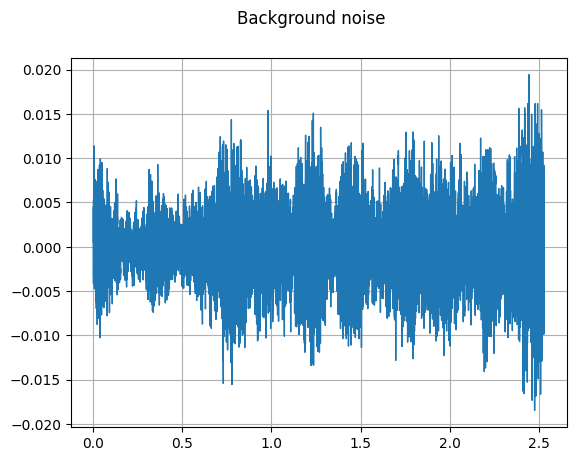

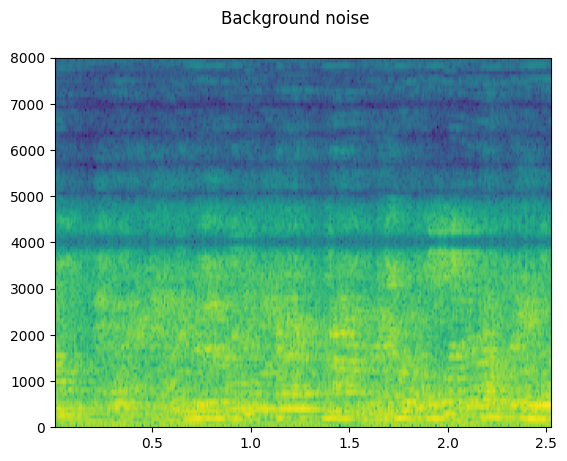

In [22]:
plot_waveform(noise, noise_sample_rate, title="Background noise")
plot_specgram(noise, noise_sample_rate, title="Background noise")
Audio(noise, rate=noise_sample_rate)

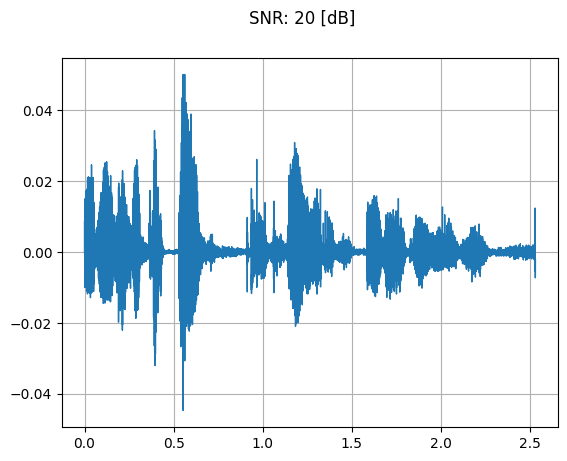

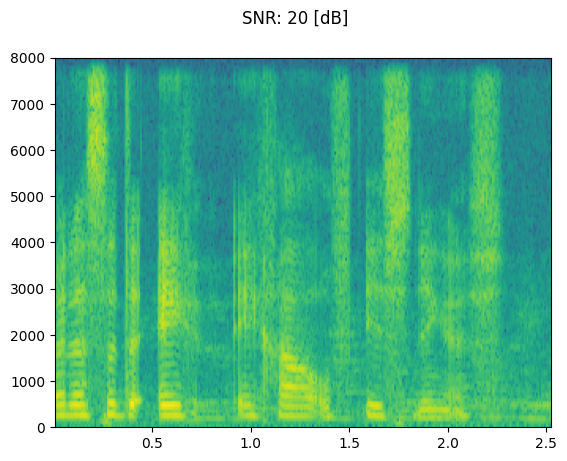

In [23]:
snr_db, noisy_speech = snr_dbs[0], noisy_speeches[0:1]
plot_waveform(noisy_speech, sample_rate1, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate1, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate1)

In [28]:
def apply_codec(waveform, orig_sample_rate, **kwargs):
    if orig_sample_rate != 8000:
        waveform = F.resample(waveform, orig_sample_rate, 8000)
        sample_rate = 8000
    augmented = F.apply_codec(waveform, sample_rate, **kwargs)
    # resample to original sample rate
    augmented = F.resample(augmented, sample_rate, orig_sample_rate)
    return augmented
# resample to 8kHz
configs = [
    {"format": "wav", "encoding": "ULAW", "bits_per_sample": 8},
    {"format": "gsm"},
    {"format": "vorbis", "compression": -1},
]
waveforms = []
for param in configs:
    augmented = apply_codec(waveform1, sample_rate1, **param)
    waveforms.append(augmented)

/home/eghaleb/anaconda3/envs/nlu/lib/python3.9/site-packages/torchaudio/backend/sox_io_backend.py:416: UserWarning: File-like object support in sox_io backend is deprecated, and will be removed in v2.1. See https://github.com/pytorch/audio/issues/2950 for the detail.Please migrate to the new dispatcher, or use soundfile backend.
  warnings.warn(_deprecation_message)
/home/eghaleb/anaconda3/envs/nlu/lib/python3.9/site-packages/torchaudio/backend/sox_io_backend.py:235: UserWarning: File-like object support in sox_io backend is deprecated, and will be removed in v2.1. See https://github.com/pytorch/audio/issues/2950 for the detail.Please migrate to the new dispatcher, or use soundfile backend.
  warnings.warn(_deprecation_message)
[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
formats: gsm can't encode GSM to 16-bit
formats: vorbis can't encode Vorbis to 16-bit


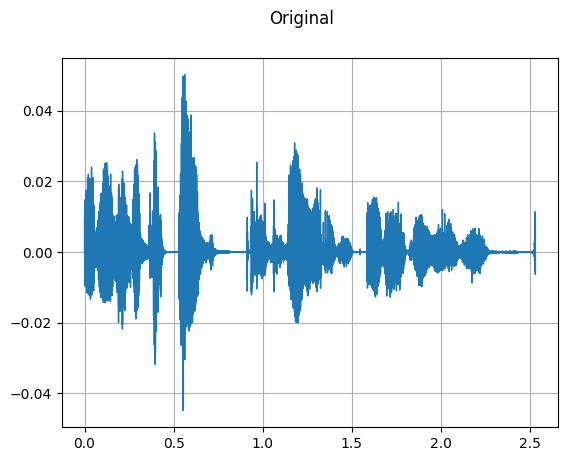

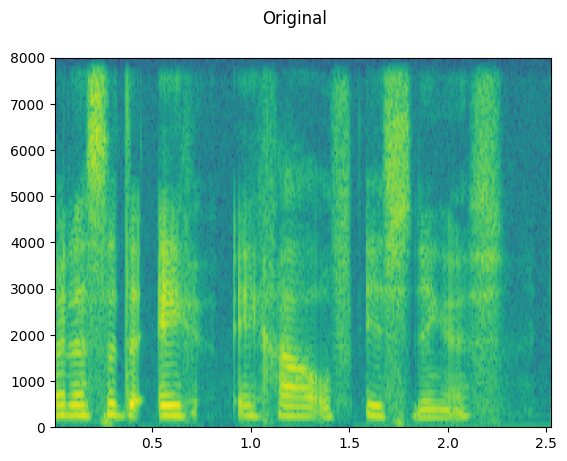

In [29]:
plot_waveform(waveform1, sample_rate1, title="Original")
plot_specgram(waveform1, sample_rate1, title="Original")
Audio(waveform1, rate=sample_rate1)

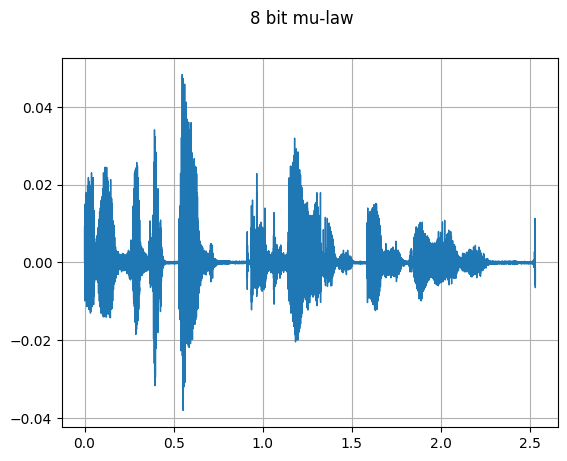

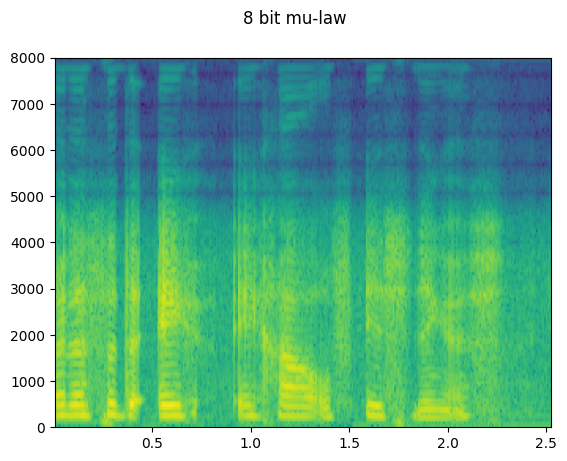

In [30]:
plot_waveform(waveforms[0], sample_rate1, title="8 bit mu-law")
plot_specgram(waveforms[0], sample_rate1, title="8 bit mu-law")
Audio(waveforms[0], rate=sample_rate1)

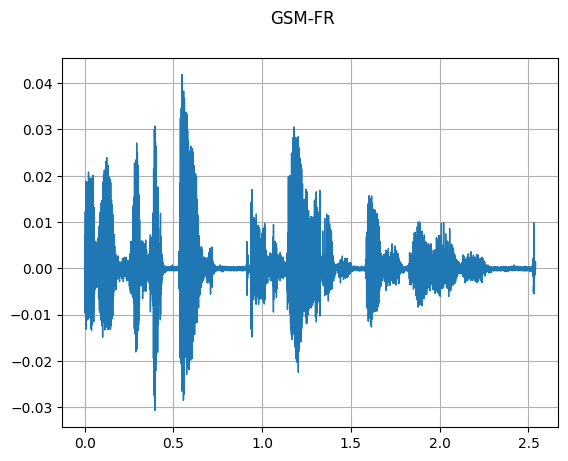

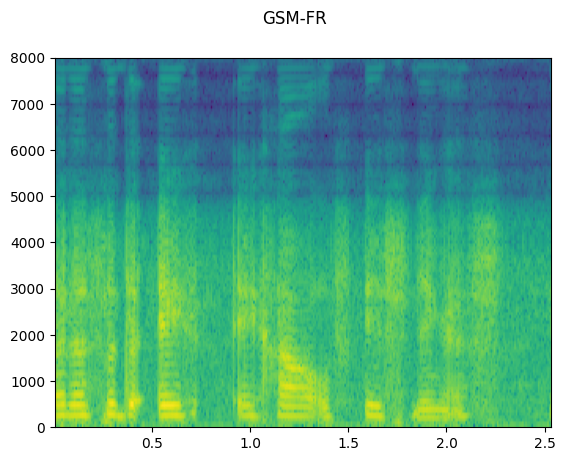

In [31]:
plot_waveform(waveforms[1], sample_rate1, title="GSM-FR")
plot_specgram(waveforms[1], sample_rate1, title="GSM-FR")
Audio(waveforms[1], rate=sample_rate1)